# Homework #7: Due October 29th, 2020, 11:59pm
## Hamiltonian Monte Carlo for Bayesian Logistic Regression

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:** Assaraf David

**Students collaborators:** Ancel Gael, Pellegrin Raphael

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import autograd.numpy as np
import itertools as it
from mpl_toolkits import mplot3d
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from pymc3 import Model
import pymc3 as pm
import matplotlib.pyplot as plt
import sys
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [56]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        
        i += 1
        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

## Problem Description: Inference for Bayesian Logistic Regression Models
In In-Class Exercise 10.13, we studied the problem of how to evaluate the classification probabilites outputed by a Logistic Regression model using calibration plots. Calibration plots are computed using observed data (data that is part of or similar to our training set). In this homework, we evaluate the usefulness of the predictive uncertainties Logistic Regression models and Bayesian Logistic Regression models for test data that are dissimilar to our training data. These test data points are called ***out of distribution (OOD) points***. Just as in Homework #2, we want the predictive uncertainties from our models to help us distinguish ***in-distribution*** test data (test data that are similar to data on which we trained our model) and OOD test data. Again, in many safety-critical applications of ML, we want human-experts to override model decisions if the model is operating on extremely unfamiliar data.


### Part I: Interpreting the Classification Probabilites of Logistic Regression as Uncertainties

**Exercise 1: (The Need for Useful Uncertainties in Classification)** Explain why OOD detection may be crucial for classifiers deployed in risk-adverse applications. Be concrete: choose a real-life domain application, identify the real-life consequences of an incorrect classification, explain *exactly* how OOD detection can help mitigate the risk of an incorrect classification. Feel free to use the following list of articles to help construct your answer.

**Reference:**
1. [Facial Recognition Is Accurate, if You’re a White Guy](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html)
2. [IBM Builds a More Diverse Million-Face Dataset to Help Reduce Bias in AI](https://techcrunch.com/2019/01/29/ibm-builds-a-more-diverse-million-face-dataset-to-help-reduce-bias-in-ai/)
3. [Wrongfully Accused by an Algorithm](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html)
4. [Gender imbalance in medical imaging datasets produces biased classifiers for computer-aided diagnosis](https://www.pnas.org/content/pnas/early/2020/05/19/1919012117.full.pdf)

**In modern artificial intelligence, data rules. A.I. software is only as smart as the data used to train it.** (*Source: NYT, Facial Recognition Is Accurate, if You’re a White Guy*). Therefore, the performances of our pattern recognition algorithm, that will leverage A.I. is heavily dependent on the quality of our data. If our data is biased, our model will be biased. If our data is wrong, our model will be wrong: **'trash-in, trash-out'** (*Source: Kevin Rader, CS109a*).

We are not afraid that something wrong would happen during the training phase: we are not at the decision step. However, after model deployment and testing phase, we would be right to be afraid that our model is completely wrong. There may be several reasons why our model could be completely wrong, arising from the different types of error for a model:
- Aleatoric uncertainty (noise in our data, independent of the training data)
- Epistemic uncertainty = model uncertainty (uncertainty in regions with a lots of trainings examples, come from the fact that our training data is a **sample** of the distribution) + OOD uncertainty (uncertainty from predicting on some data we have never seen). 

Aleatoric and model uncertainty are inherent to the modelling phase. However, OOD is not inherent and we might want our model to **reflect** its uncertainty on OOD data points. We do not want our model to be overly confident when predicting on things it has never seen. This is even more true when we are working in risk-adverse applications. 

I have worked on a Computational Cardiology laboratory. My task there was to devise an 'Automatic Cardiologist' that would predict the pathology of a patient based on its 12-leads ECG + some metadata. The pathology that would be predicted was drawn from 27 different pathologies previously selected (from whih we built a solid understanding and precise biomarkers in order to be detected). Let us say that I deploy my model in a hospital and that one patient comes up with a pathology that is not amongst the aforementionned pathologies. Furthermore, worst-case scenario, my model is not fit in order to produce reliable OOD uncertainty, and it predicts that this patient's pathology is SNR (normal sinus rhythm) with a probability of 98%. Therefore, if I only rely on the algorithm's decision, I would predict that this patient is doing great ! Whereas he could have a very serious pathology I have never seen. This is where **OOD uncertainty** intervenes: if my model was able to somehow say 'I am not sure of my prediction because I have never seen such an ecg before', then we would leverage human intervention in order to make an informed decision. This is why OOD uncertainty is so important for models.

**Exercise 2: (Classifying OOD MNIST Digits)** In In-Class Exercise 10.13, we interpreted the output of a Logistic Regression model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0). Explain why this is a reasonable interpretation of the classification probability. 

In this Exercise, build a Logistic Regression model to distinguish between digital images of handwritten digits (this is the MNIST dataset):

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`

For simplicity, we only look at images of digits: 1 and 6. 

In this dataset, the classes are balanced (we take 600 images of each digit). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of six test images,
`test_point_1`, ..., `test_point_6`,
report the classification probabiliy for each image under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test images.

So is this classifier a good model? Does your analysis of the model's performance via its predictive accuracy agree with your analysis of the model's performance via its predictive uncertainties? Conclude whether or not you would feel comfortable using this model in a real-life setting?

##### Interpretation of the classification probability

Let us briefly recall the Logistic Regression paradigm. We leverage Logistic Regression for Binary classification. The objective of this model is to find a hyperplane (*decision boundary*) that would separate the data. In the logistic regression, we model the **probability outcome** as a GLM inserted into a Bernoulli Variable. Therefore, we try to approximate:
$$
\hat{\mathbb{P}}(Y = 1) = sigm(X^T\beta)
$$
At the decision boundary, we have 
$$
\hat{\mathbb{P}}(Y = 1) = \hat{\mathbb{P}}(Y = 0) \iff log(\frac{\hat{\mathbb{P}}(Y = 1) }{\hat{\mathbb{P}}(Y = 0) })= 0 \iff X^T\beta = 0 
$$
Therefore, if we classify a point with a probability close to 0.5, this would mean that this point lies *close to the decision boundary*, further meaning that our model is unsure about its classification. This is why interpreting the output of a Logistic Regression model as an indicator of the confidence of the model is a reasonable interpretation. 

In [4]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [5]:
# Pick out two classes of digits: 1, 6 and take a subset of samples
X_subset = X[((y == '1') | (y == '6'))][0:600]
y_subset = y[((y == '1') | (y == '6'))][0:600]

# Encode the label '1' with y=1, and the label '6' with y=0
y_subset[y_subset == '1'] = 1
y_subset[y_subset == '6'] = 0
y_subset = y_subset.astype(int)

In [6]:
# Randomize our data
random_state = check_random_state(0)
permutation = random_state.permutation(X_subset.shape[0])
X_subset = X_subset[permutation]
y_subset = y_subset[permutation]
X_subset = X_subset.reshape((X_subset.shape[0], -1))

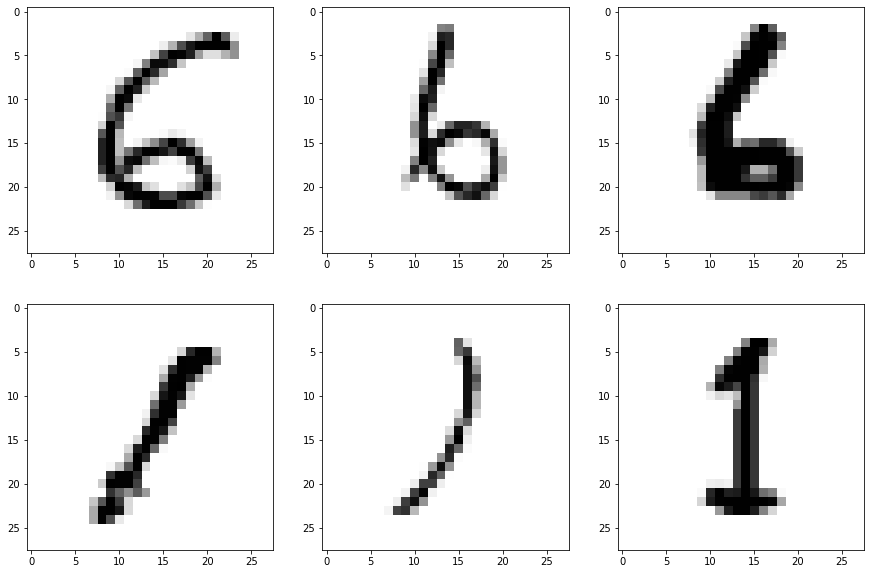

In [7]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    ax[0, i].imshow(X_subset[y_subset == 0][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1, i].imshow(X_subset[y_subset == 1][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [8]:
# Test images for evaluating your classifier
test_point_1 = X_subset[y_subset == 0][10]
test_point_2 = X_subset[y_subset == 1][10]
test_point_3 = X[y=='3'][20]
test_point_4 = np.random.normal(200, 10, size=(28 * 28, ))
test_point_5 = test_point_2 + np.random.normal(300, 10, size=(28 * 28, )) - test_point_1
test_point_6 = test_point_2 + test_point_1 + np.random.normal(100, 10, size=(28 * 28, ))

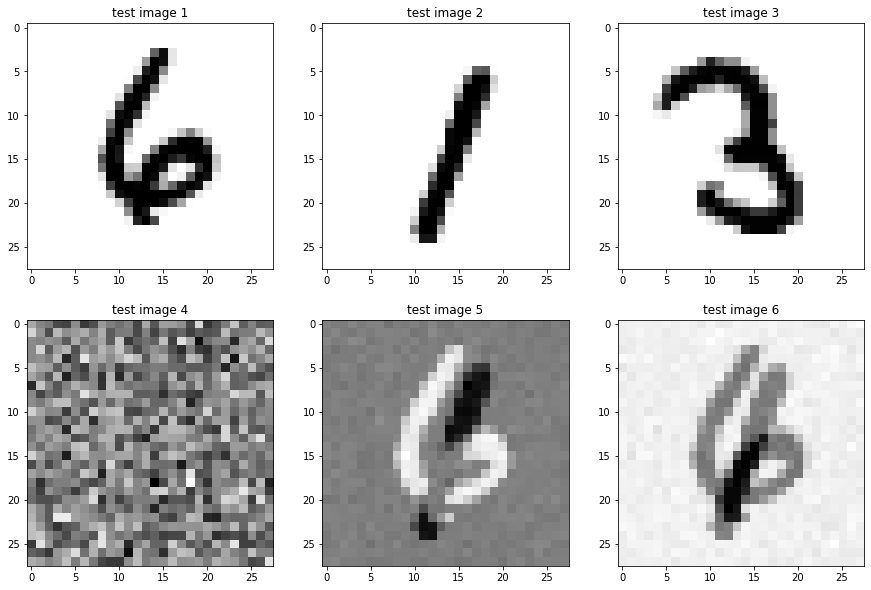

In [9]:
# Visualize some samples from the test dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(test_point_1.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 0].set_title('test image 1')
ax[0, 1].imshow(test_point_2.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 1].set_title('test image 2')
ax[0, 2].imshow(test_point_3.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 2].set_title('test image 3')
ax[1, 0].imshow(test_point_4.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 0].set_title('test image 4')
ax[1, 1].imshow(test_point_5.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 1].set_title('test image 5')
ax[1, 2].imshow(test_point_6.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 2].set_title('test image 6')
plt.show()

##### Logistic Regression model for in-distribution samples

In [10]:
from sklearn.model_selection import cross_val_score

In [11]:
lr = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
scores = np.mean(cross_val_score(lr, X_subset, y_subset, cv = 10, scoring='accuracy'))
print('The mean Validation accuracy for a Logistic Regression model is ', scores)

The mean Validation accuracy for a Logistic Regression model is  0.9883333333333333


Here, we have not printed the training score but the **cross-validation score**, which is the score of our model when being evaluated on portions of the training data he has never seen. The reason why the validation accuracy is that high is because the distribution of the training samples is very homogeneous. Based on the validation accuracy, I would tend to say that our model is a good model (when only basing our diagnostic on predictive performance). Let us fit it then ! 

In [12]:
lr.fit(X_subset, y_subset)

LogisticRegression(solver='saga', tol=0.1)

##### OOD Uncertainty

In [13]:
ps = []
for test_point in [test_point_1, test_point_2, test_point_3, test_point_4, test_point_5, test_point_6]:
    p = lr.predict_proba(test_point.reshape(1, -1))
    ps.append(p)

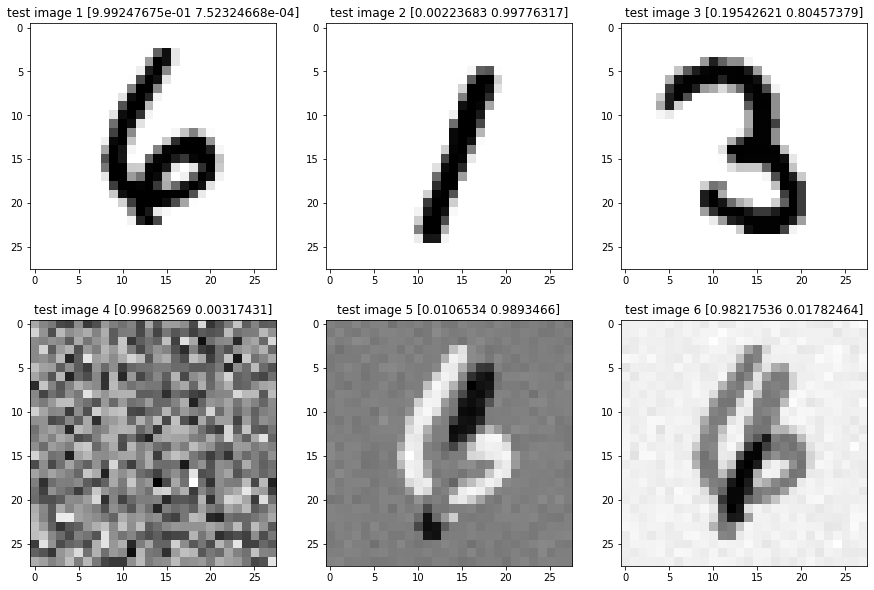

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(test_point_1.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 0].set_title('test image 1 ' + str(*ps[0]))
ax[0, 1].imshow(test_point_2.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 1].set_title('test image 2 ' + str(*ps[1]))
ax[0, 2].imshow(test_point_3.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 2].set_title('test image 3 ' + str(*ps[2]))
ax[1, 0].imshow(test_point_4.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 0].set_title('test image 4 ' + str(*ps[3]))
ax[1, 1].imshow(test_point_5.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 1].set_title('test image 5 ' + str(*ps[4]))
ax[1, 2].imshow(test_point_6.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 2].set_title('test image 6 ' + str(*ps[5]))
plt.show()

We can see that our model **does not behave well at all** for OOD uncertainty. Indeed, from its behavior on the test data, we can see several patterns: 
- Our model has *never* seen the digit 3 during his training, though he is very confident when classifying this 3 as a 1. 
- For the test image 4, the human eye is not even able o distinguish which number it is. However, our model predicts with high confidence that this image is a 1. Here, we might say that this is due to the representation of the image (the computer sees some pixels and not some images), but we know that this image is just a random noise!
- For the last two test images, the same behavior occurs: lots of noise, image undistinguishable, and our model is very confident with the classification of this test image.

Therefore, from our perspective, this model is *not a good model*. Though its predictive acuracy is quite high, it performs overly-confident predictions and the predictive uncertainty is completely off. I would not recommend using this model in a real-life setting because it could lead to making disastrous decisions. 

*Personal note: Cause of this situation = linear decision boundaries that split the space into two subspaces and being 'close' to the boundary is a hard constraint that would be quite never met in high dimensionality.* 

**Exercise 3: (Classifying OOD Data for a Toy Dataset)** In this Exercise, build a Logistic Regression model to distinguish between two classes in our toy classification dataset:

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)` 

In this dataset, the classes are balanced (we have 100 points in each class). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of test points,
`test_points`,
report the classification probabiliy for each test point under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test points, identify which of these test points are in-distribution and which ones are OOD.

Relate your analysis of the behaviour of Logistic Regression on this toy dataset to its performance on MNIST. Can you come up with some hypotheses for exactly when the classification probability indicates an inappropriate amount of certainty when predicting on test points?

In [15]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

In [16]:
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

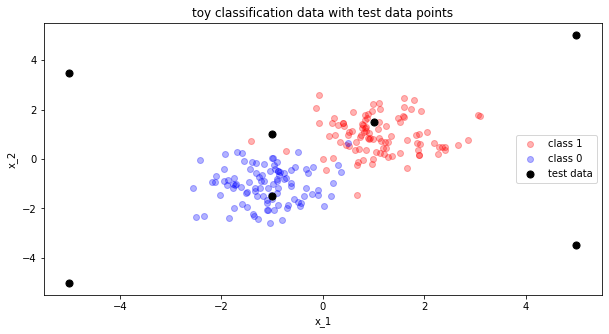

In [17]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

##### Logistic Regression model for in-distribution samples

In [18]:
lr = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
scores = np.mean(cross_val_score(lr, x, y, cv = 10, scoring='accuracy'))
print('The mean Validation accuracy for a Logistic Regression model is ', scores)

The mean Validation accuracy for a Logistic Regression model is  0.9649999999999999


Here, we have not printed the training score but the **cross-validation score**, which is the score of our model when being evaluated on portions of the training data he has never seen. The reason why the validation accuracy is that high is because the distribution of the training samples is very homogeneous. Based on the validation accuracy, I would tend to say that our model is a good model (when only basing our diagnostic on predictive performance). Let us fit it then ! 

In [19]:
lr.fit(x, y)

LogisticRegression(solver='saga', tol=0.1)

##### Behavior of the Logistic Regression for OOD samples

In [20]:
ps = []
for test_point in test_points:
    p = lr.predict_proba(np.asarray(test_point).reshape(1, -1))
    ps.append(p)

In [21]:
ps_plot = [np.asarray([round(p[0][0], 4), round(p[0][1], 3)]) for p in ps]

##### Boundary decision for the Logistic Regression classifier

The boundary decision is defined by 
$$
\beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2}=0
$$
Therefore, here, the boundary line is:
$$
X_2 = -\frac{\beta_1}{\beta_2}X_1 - \frac{\beta_0}{\beta_2}
$$

In [22]:
slope = lambda x: -lr.coef_[0][0]/lr.coef_[0][1]*x - lr.intercept_[0]/lr.coef_[0][1] 

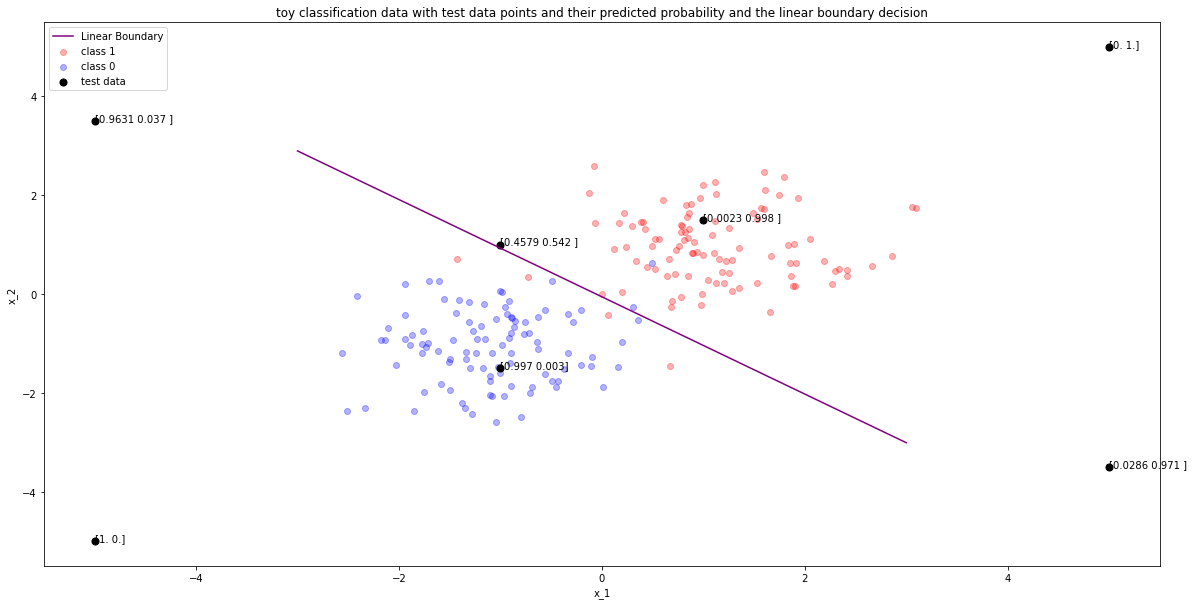

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(np.linspace(-3, 3, 100), [slope(xi) for xi in np.linspace(-3, 3, 100)], color='purple', label='Linear Boundary')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
for i, txt in enumerate(ps_plot):
    ax.annotate(txt, (test_points[i][0], test_points[i][1]))
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and their predicted probability and the linear boundary decision')
ax.legend(loc='best')
plt.show()

From the above visualization, several patterns appear regarding the predictive uncertainty of this model. 

Regarding non OOD uncertainty:
- The in-Distribution samples behave well: they are well predicted, and the probability for these predictions are high
- The samples that lie close to the boundary are predicted with low confidence (we can see that there is a drop in probability confidence for this test point)

Regarding OOD uncertainty:
- We can see that the four points lying at the extreme of the box are OOD samples. They are lying far from the sampels drawn from the two multivariate normal gaussian. However, the predictions of our model are quite off: our model predicts this point with high confidence. These predictive uncertainties do not make sense for OOD samples.

Regarding the analysis we just conducted and the previous experiments with the MNIST dataset, we can draw some conclusions regarding the behavior of the predictive uncertainty for Logistic Regression. The classification probability indicates an inappropriate amount of certainty when predicting on test points when the test points are **far from the boundary**, independently of how far they are. For instance, in the toy dataset, the four test points are far from the classification boundary, so the model is over confident for their predictions. However, these test points are also **far from the training distributions**, and our model does not capture this behaviour. This is due to the shape of the boundary decision, which is a linear shape: we do not wrap our in-distribution samples.

### Part II: Interpreting the Uncertainties of Bayesian Logistic Regression

**Exercise 4: (Classifying OOD Data for a Toy Dataset with Bayesian Logistic Regression)** 
In Exercise 2 and 3, we examined one source of uncertainty from a logistic model: the classification probability. There is another source of uncertainty: uncertainty over the model itself (which decision boundaries can fit the dataset).

Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
w_i &\sim \mathcal{N}(0, 10)\\
Y^{(n)} &\sim Ber(\text{sigm}(w_2 X_1^{(n)} + w_1 X_2^{(n)} + w_0))
\end{align}

where $w_i$, $Y^{(n)}$, $X_i^{(n)}$ are real scalar valued random variables, and where the data consists of the observations $(x_1^{(n)}, x_2^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$.

We suggest using the following settings for your HMC:

```python
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = np.hstack((logistic.coef_.flatten(), logistic.intercept_))
position_init = position_init.reshape((1, 3))
#leap-frog step size
step_size = 1e-1
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 5000
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 1
```

where `logistic.coef_` and `logistic.intercept_` are the learned parameters of your `sklearn` Logistic regression model you trained in Exercise 3. 

Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Logistic Regression model (see In-Class Exercise 10.13). What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

##### From target pdf to Optimization function

First, we need to define the target distribution we need to sample from. This target distribution is the posterior $p(w|Y)$ of the Bayesian Logistic Regression Model with covariates. Since we did not choose a conjugate prior regarding the likelihood, there will be no close form for the target distribution. 

$$
p(w|\mathcal{D}) \propto p(\mathcal{D}|w)p(w) \propto \prod_{i=1}^N sigm(w^TX^{(i)})^{y^{(i)}}(1-sigm(w^TX^{(i)}))^{1-y^{(i)}}e^{-\frac{w^2}{20}} \propto \prod_{i=1}^N(e^{w^TX^{(i)}})^{y^{(i)}}(1-sigm(w^TX^{(i)}))e^{-\frac{w^2}{20}} \quad \propto e^{-\frac{w^2}{20}}\prod_{i=1}^Ne^{y^{(i)}w^TX^{(i)}}(1-sigm(w^TX^{(i)}))
$$

Then, in order to combine the paradigm from optimization into sampling, in order to find the zones where the target distribution will have high density, we turn this target distribution into an energy function:
$$
U(w) = -log(p(w|\mathcal{D})) = \frac{||w||^2}{20} - \sum_{i=1}^N y^{(i)}w^TX^{(i)} - log(1-sigm(w^TX^{(i)}))
$$

Let us visualize the Potential Energy function. Since it has 3 parameters, we will block one ($w_0$) and visualize how this potential energy varies according to the two parameters $w_1$ and $w_2$.


In [24]:
d = 3
Sigma= 10*np.eye(d)
Sigma_inv= np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)

def log_prior(w):
    D = len(w)
    logprior = -0.5 * (np.log(Sigma_det) + D * np.log(2 * np.pi))
    logprior += -0.5 * np.dot(np.dot(w, Sigma_inv), w.T)
    return logprior

def log_likelihood(w):
    theta = sigmoid(w[0] + np.dot(x, w[1:])) 
    loglkhd = y * np.log(theta) +  ( 1 - y ) * np.log( 1 - theta )
    return np.sum(loglkhd)

def log_target(w):
    return log_prior(w) + log_likelihood(w)


U = lambda q: -log_target(q)
grad_U = grad(U)

##### Visualizing the Optimization landscape

In [25]:
def plot_surface_3d(w0):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection="3d")
    w1 = np.linspace(-10, 40, 60)
    w2 = np.linspace(-5, 5, 60)
    W1, W2 = np.meshgrid(w1, w2)
    Z = np.zeros(3600).reshape(60, 60)
    for i in range(len(W1)):
        for j in range(len(W2)):
            Z[i][j] = U(np.asarray([w0, w1[i], w2[j]]))
    pl = ax.plot_surface(W1, W2, Z, rstride=1, cstride=1, cmap='autumn', edgecolor='none')
    fig.colorbar(pl, ax=ax, shrink=0.5, aspect=5)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('Potential Energy')
    ax.set_title('U(w0, w1, w2), w0 = ' +str(w0))
    plt.show()

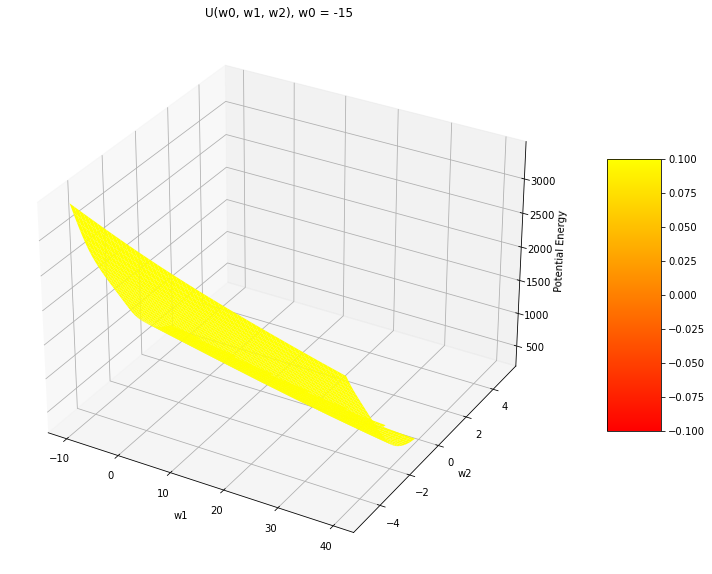

In [26]:
plot_surface_3d(-15)

##### Hamiltonian movement

Now, that we have defined the potential energy which is the optimization landscape, we need to choose a Kinetic Energy function. This Kinetic Energy function will allow us to simulate the movement of a particle on the landscape of $U$, in order to replicate some kind of *random Gradient Descent*. 

We will use the **Euclidean-Gaussian kinetic energy** which allow to easily draw samples from its conjugate Gibbs Distribution. 
Here, $w \in \mathbb{R}^3$. We will define the mass of this system to be $M = m \mathbf{I}_{3\times 3}$, where $m$ will be tuned later on. Now, we can define the Kinetic Energy function as :
$$
K(p) = \frac{1}{2} p^\top M^{-1} p + \frac{1}{2}\log|M| + \frac{D}{2} \log(2\pi)
$$

In order to sample from this Kinetic Energy some random momentums, we need to define its conjugate Gibbs distribution, 
$$
\pi(p) = \frac{1}{Z}\exp\{-K(p)\} = \frac{1}{Z} \frac{1}{(2\pi)^{D/2}|M|^{1/2}} \exp\left\{-\frac{1}{2}p^\top M^{-1} p\right\}
$$

We now clearly the advantages of using this specific Kinetic Energy: the Gibbs Distribution is a multivariate Gaussian $\mathcal{N}(\mu, \Sigma)$, with mean $\mu = 0_{\mathbb{R}^3}$ and $\Sigma = M$.


Now that we have defined the potential Energy and the Kinetic Energy functions, we can define the Hamiltonian of the system and derive the equations that will dictate the movement of a particle moving on the landscape of $U$ with a random initial momentum (**push**) $q$ drawn from the Gibbs Distribution of $K$.

We will simulate this movement from 0 to $T$ thanks to the Hamiltonian and the equations governing momentum and position. However, since we cannot integrate exactly the Hamiltonian equations, we are going to use Sympletic Integrators. In our case, we will use **Leap-Frog Integrator**. 

The Leap-Frog integrator discretizes the time from 0 to $T$ and performs iterative updates in order to approximate the value of $(p, q)$ at every step of time. The Leap Frog algorithm in order to approximate the end state $(p^{(T)}, q^{(T)})$ is : 

$\quad$**B.** (**simulate movement**) simulate Hamiltonian motion for $L$ steps each with time interval $\epsilon$, using the leap-frog integrator. <br>
$\quad$$\quad$**a.** Repeat for T - 1 times, for $p^{(\text{step } 0)} = p^{(current)}$, $q^{(\text{step } 0)} = q^{(current)}$:<br>
$\quad$$\quad$$\quad$**i.** (**half-step update for momentum**) $p^{(\text{step } t + 1/2)} \leftarrow  p^{(\text{step } t)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t)})$<br>
$\quad$$\quad$$\quad$**ii.*** (**full-step update for position**) $q^{(\text{step } t + 1)} \leftarrow q^{(\text{step } t)} + \epsilon \frac{\partial K}{\partial p}(p^{(\text{step } t}))$<br>
$\quad$$\quad$$\quad$**iii.** (**half-step update for momentum**)$p^{(\text{step } t + 1)} \leftarrow  p^{(\text{step } t + 1/2)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t + 1)})$<br>
$\quad$$\quad$**b.** (**reverse momentum**) $p^{(\text{step } T)} \leftarrow -p^{(\text{step } T)}$<br>

Therefore, in order to implement the Leap-Frog integrator algorithm, we will need two quantities: $\frac{\partial K}{\partial p}$ and $\frac{\partial U}{\partial q}$. Although it might be hard to get the analytical expression of $\frac{\partial U}{\partial q}$, it might be easier to get $\frac{\partial K}{\partial p} = \frac{1}{m}p$. In order to get $\frac{\partial U}{\partial q}$, we will use Automatic Differentiation. 

In [27]:
def kinetic_energy(p):
    return 1/2*np.dot(np.dot(p.T, np.linalg.inv(M)), p) + 1/2*np.log(np.linalg.det(M)) + p.shape[0]/2*np.log(2*np.pi)

In [28]:
def simulate_movement(p0, q0, step_size, steps, m):
    p_t, q_t = p0, q0
    for _ in it.repeat(None, steps):
        p_half = p_t - (step_size/2.)*grad_U(q_t)
        q_t = q_t + step_size*partial_derivative_K(m, p_half)
        p_t = p_half - (step_size/2)*grad_U(q_t)
    p_T = -p_t # reverse momentum
    q_T = q_t
    return p_T, q_T    

##### Correcting the Leap-Frog Estimator

The last step of Hamiltonian Monte-Carlo is to correct the approximations we might have made during the sampling procedure. Where can errors come from ? We know that exact HMC is a correct MCMC sampler. However, here we perform non-exact HMC: we approximated it using the leap-frog integrator. Therefore, when our number of steps or our step size is unappropriate, our final potision $p^{(step T)}$ might be off. Therefore, we add a **Metropolis-Hastings** step in order to accept or reject the current proposition. 

3. (**correction for simulation error**) implement Metropolis-Hasting accept mechanism: 
    1. compute $\alpha = \min\left(1, \exp\left\{H(q^{(current)}, p^{(current)}) - H(q^{(\text{step } T)}, p^{(\text{step } T)})\right\} \right)$
    2. sample $U\sim U(0, 1)$, if $U \leq \alpha$ then accept, else keep old sample

In [29]:
def metropolis_hastings(p_current, q_current, p_proposal, q_proposal, kinetic_energy, potential_energy):
    current_H = kinetic_energy(p_current) + potential_energy(q_current)
    proposed_H = kinetic_energy(p_proposal) + potential_energy(q_proposal)
    acceptance_rate = min(1, np.exp(current_H - proposed_H))
    U = np.random.uniform()
    if U <= acceptance_rate:
        return p_proposal, q_proposal
    return p_current, q_current

##### Tying it all together

In [30]:
d = 3
Sigma= 10*np.eye(d)
Sigma_inv= np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)

def log_prior(w):
    D = len(w)
    logprior = -0.5 * (np.log(Sigma_det) + D * np.log(2 * np.pi))
    logprior += -0.5 * np.dot(np.dot(w, Sigma_inv), w.T)
    return logprior

def log_likelihood(w):
    theta = sigmoid(w[0] + np.dot(x, w[1:])) - 0.0000001
    loglkhd = y * np.log(theta) +  ( 1 - y ) * np.log( 1 - theta )
    return np.sum(loglkhd)

def log_target(w):
    return log_prior(w) + log_likelihood(w)


U = lambda q: -log_target(q)
grad_U = grad(U)


def partial_derivative_K(p):
    return p/m

def kinetic_energy(p):
    return 1/2*np.dot(np.dot(p.T, np.linalg.inv(M)), p) + 1/2*np.log(np.linalg.det(M)) + p.shape[0]/2*np.log(2*np.pi)

H = lambda p, q : U(q) + kinetic_energy(p)   #before, tu utilisais K(p), check si c'est good

def simulate_movement(p0, q0, kinetic_energy, potential_energy, step_size, steps):
    p_t, q_t = p0, q0
    for _ in it.repeat(None, steps):
        p_half = p_t - (step_size/2.)*grad_U(q_t)
        q_t = q_t + step_size*partial_derivative_K(p_half)
        p_t = p_half - (step_size/2)*grad_U(q_t)
    p_T = -p_t # reverse momentum
    q_T = q_t
    return p_T, q_T    


def metropolis_hastings(p_current, q_current, p_proposal, q_proposal, kinetic_energy, potential_energy):
    acceptance_rate = min(1, np.exp(H(p_current, q_current) - H(p_proposal, q_proposal)))
    U = np.random.uniform()
    if U <= acceptance_rate:
        return p_proposal, q_proposal
    return p_current, q_current


def Hamiltonian_Monte_Carlo_one_sample(q0, kinetic_energy, potential_energy, step_size, steps):
    p0 = np.random.multivariate_normal(np.zeros(q0.shape[0]), M) # kick-off
    p_proposed, q_proposed = simulate_movement(p0, q0,  kinetic_energy, potential_energy, step_size, steps) # movement
    p_mh, q_mh = metropolis_hastings(p0, q0, p_proposed, q_proposed, kinetic_energy, potential_energy) # correct error
    return p_mh, q_mh


In [31]:
#mass 
D = 3
m = 1
M = m*np.eye(D)
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = np.hstack((lr.coef_.flatten(), lr.intercept_))
position_init = position_init.reshape((1, 3))[0]
#leap-frog step size
step_size = 1e-1
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 5600  
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 1



position_init = np.hstack((lr.coef_.flatten(), lr.intercept_))
position_init = position_init.reshape((1, 3))[0]
qs = [position_init]
for _ in it.repeat(None, total_samples):
    sample = Hamiltonian_Monte_Carlo_one_sample(qs[-1], kinetic_energy, U, step_size, leapfrog_steps)[1]
    qs.append(sample)
    
samples = np.asarray(qs)
burn_in = int(burn_in*total_samples)
samples = samples[burn_in:]
samples = samples[::thinning_factor]

##### Visualization of the posterior distribution

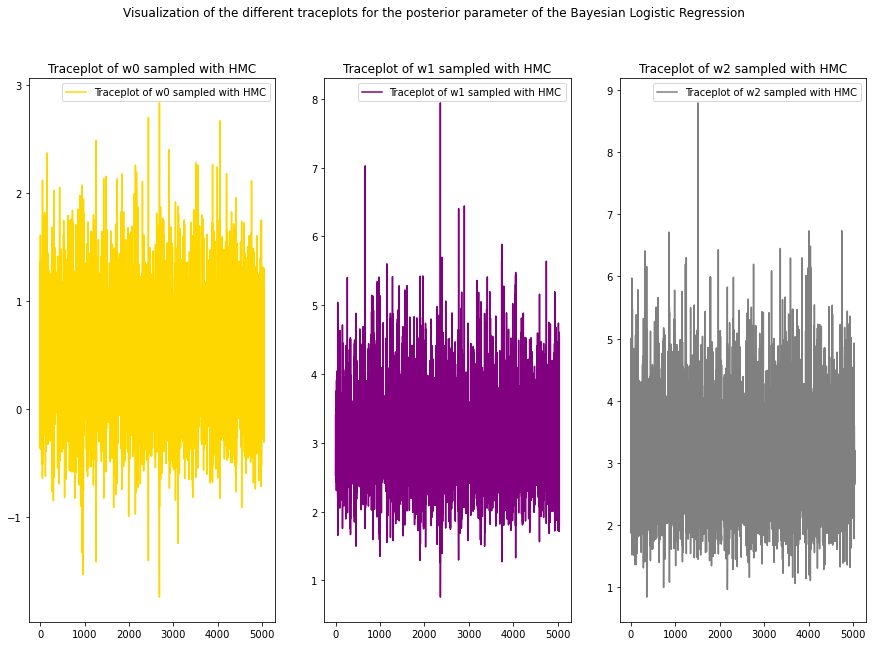

In [32]:
fig, axes = plt.subplots(1, 3, figsize = (15, 10))
c = ['gold', 'purple', 'gray']
fig.suptitle('Visualization of the different traceplots for the posterior parameter of the Bayesian Logistic Regression')
for i in range(d):
    axes[i].set_title('Traceplot of w'+str(i)+' sampled with HMC')
    axes[i].plot(samples[:, i], color = c[i], label = 'Traceplot of w'+str(i)+' sampled with HMC')
    axes[i].legend()
plt.show(fig)

##### Sampler diagnostics

##### Decision boundaries for the posterior distribution 

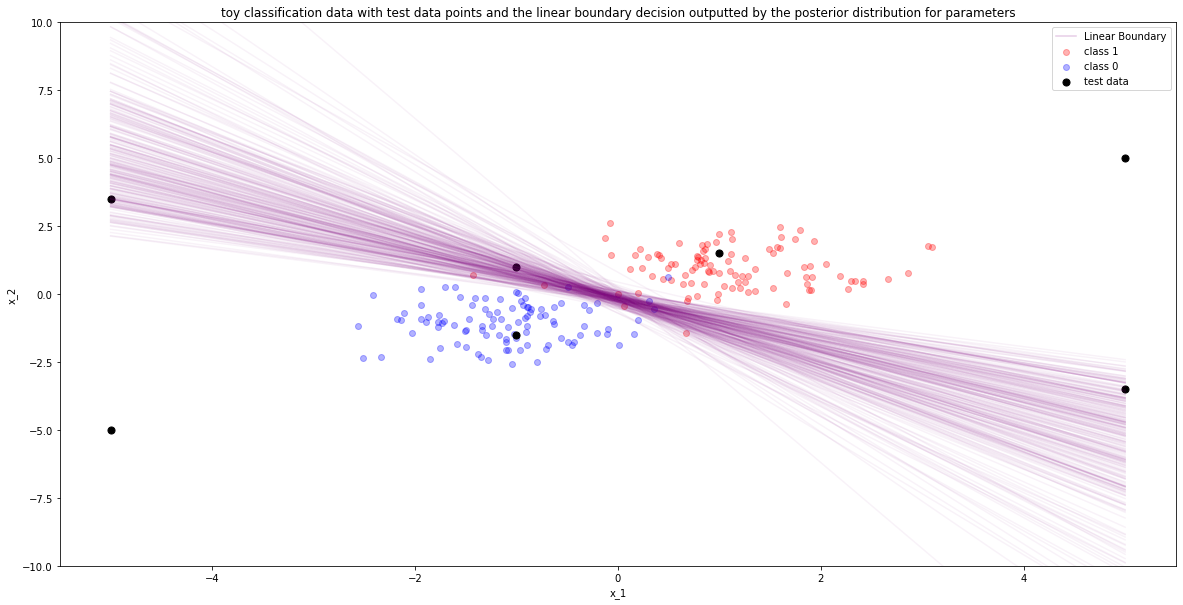

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for sample in samples:
    slope = lambda x :  -sample[1]/sample[2]*x - sample[0]/sample[2]
    if np.random.uniform()< 0.05:
        ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', alpha=0.05)
ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', label='Linear Boundary', alpha=0.2)
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_ylim(-10, 10)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and the linear boundary decision outputted by the posterior distribution for parameters')
ax.legend(loc='best')
plt.show()

Therefore, we can see that leveraging a **distribution** over the model parameters and visualizing the decision boundary for the distribution over the parameters enabled us to be less confident around the boundaries of the separation of the data. This would mean that, computing probabilities thanks to these parameter distribution would allow us to have more consistent predictions and a predictive uncertainty more reliable. For instance, 2 test points now lie within the boundaries of our distribution of models, which was not the case for the MLE of our parameters. However, one persistent drawback is the *geometry* of our boundary, which still does not allow to clearly separate OOD from in-distribution (these 2 new points now lie at the boundary out of some 'luck').  

**Exercise 5: (Epistemic Uncertainty from Bayesian Logistic Regression)** Since the posterior $p(\mathbf{w} | \mathcal{D}))$ is a distribution over multiple models (i.e. decision boundaries) and each model outputs a classification probability for each test data point, the posterior $p(\mathbf{w} | \mathcal{D}))$ defines a distribution of classification probabilities for each test point. The variance of the distribution over classification probabilities is one way of quantifying the amount of ***epistemic uncertainty*** - uncertainty due to lack of observed training data - of the model at a particular test point.

Estimate the average epistemic uncertainty, under the posterior $p(\mathbf{w} | \mathcal{D}))$, of the data points in the toy data set, then estimate the epistemic uncertainty of each test data point. Interpret these uncertainties, in particular, explain to what extend can the epistemic uncertainties of this Bayesian Logistic Regression model be used to distinguish in-distribution points from OOD points. 

Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

##### Estimating Epistemic Uncertainty

Now that we are able to sample parameters from the posterior distribution, we are able to get a distribution over the possible parameters for our Bayesian Logistic Regression. These different parameters drawn from the posterior distribution will lead to different Logistic Regression models, providing us with different modelling of the probabilities of the binary classification task. Therefore, we will benefit from various probabilities for every data point. We will interpret these various probabilities as an indication of the model's predictive uncertainty.

##### Average Epistemic Uncertainty for in-Distribution points

We are going to compute the probability $\hat{\mathbb{P}}(y=1)$ for every training point and every model parameter. Next, we will estimate the variance of these probabilities. 

In [34]:
global_variance = []
for x_point in x:
    probabilities_x = [] 
    for sample in samples:
        proba_x = sigmoid(np.dot(sample, np.hstack(np.asarray([1, x_point]))))
        probabilities_x.append(proba_x)
    global_variance.append(np.std(probabilities_x))

In [35]:
test_variance = []
for test_point in test_points:
    probabilities_test = [] 
    for sample in samples:
        proba_test = sigmoid(np.dot(sample, np.hstack(np.asarray([1, test_point]))))
        probabilities_test.append(proba_test)
    test_variance.append(np.std(probabilities_test))

Now, we are going to visualize the variance of the predictions for every point in our training set and testing set. The goal is to visualize which points present a high epistemic uncertainty. 

In [36]:
test_variance_plot = [round(var, 3) for var in test_variance]
train_variance_plot = [round(var, 3) for var in global_variance]

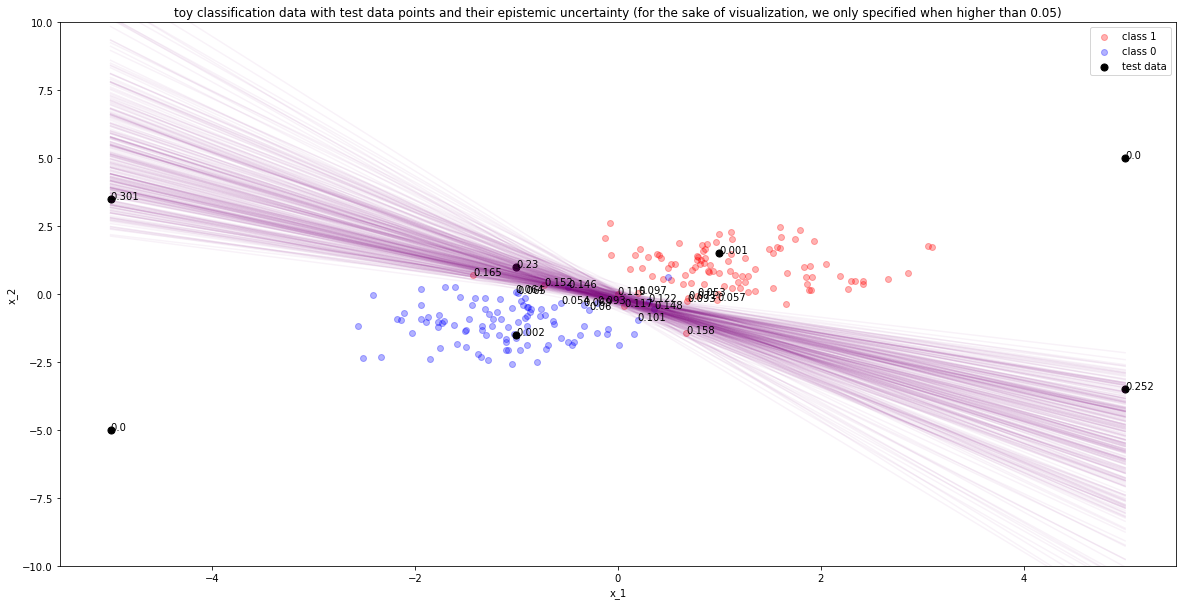

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for sample in samples:
    if np.random.uniform()<0.05:
        slope = lambda x :  -sample[1]/sample[2]*x - sample[0]/sample[2]
        ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', alpha=0.05)
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
for i, txt in enumerate(test_variance_plot):
    ax.annotate(txt, (test_points[i][0], test_points[i][1]))
for i, txt in enumerate(train_variance_plot):
    if float(txt) > 0.05: 
        ax.annotate(txt, (x[i][0], x[i][1]))
ax.set_ylim(-10, 10)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and their epistemic uncertainty (for the sake of visualization, we only specified when higher than 0.05)')
ax.legend(loc='best')
plt.show()

We can see that the epistemic uncertainty is still not a reliable measure to allow to differentiate in-distribution points from OOD points: even after sampling a parameter distribution, all of our different models are very confident with classifying points really far from the linear decision boundary, that might be OOD points. 

From the above plot, we can see that the amount of epistemic uncertainty at a data point is directly related to its distance to the decision boundary in the posterior $p(w|\mathcal{D})$. Therefore, the epistemic uncertainties of our Bayesian Logistic Regression model is not capable of distinguishing all possible OOD points because of the shape of the decision boundary, that will not distinguish OOD points far from the boundary and the distributions. 

**Exercise 6: (Classifying OOD Data for a Toy Dataset with Bayesian Non-linear Logistic Regression)** 
Just as we can cast Bayesian Non-linear Regression as a non-linear transformation of the data followed by Bayesian Linear Regression, we can perform Bayesian Logistic Regression with non-linear decision boundaries by first applying a non-linear feature map to the data and then fitting a Bayesian Logistic Regression model on the features.

Perform Bayesian Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
\mathbf{w} &\sim \mathcal{N}(0, 10\, \mathbf{I})\\
Y^{(n)} &\sim Ber(\text{sigm}(\mathbf{w}^\top \phi(\mathbf{X}^{(n)}) ))
\end{align}

Visualize the decision boundaries corresponding to the samples in the posterior. Are the epistemic uncertainties of this Bayesian model able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

##### Changing the complexity of our model

Since we have seen before that fitting linear boundaries (via the Bayesian or Frequentist approach) does not provide the right amount of predictive uncertainty, we are going to try Bayesian Polynomial Regression in order to get more **complex decision boundaries**.

In [38]:
poly = PolynomialFeatures(degree=2).fit(x)
x_poly = poly.transform(x)

In [39]:
d = 6
Sigma= 10*np.eye(d)
Sigma_inv= np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)

def log_prior(w):
    D = len(w)
    logprior = -0.5 * (np.log(Sigma_det) + D * np.log(2 * np.pi))
    logprior += -0.5 * np.dot(np.dot(w, Sigma_inv), w.T)
    return logprior

def log_likelihood(w):
    theta = sigmoid(np.dot(x_poly, w)) - 0.0000001
    loglkhd = y * np.log(theta) +  ( 1 - y ) * np.log( 1 - theta )
    return np.sum(loglkhd)

def log_target(w):
    return log_prior(w) + log_likelihood(w)


U = lambda q: -log_target(q)
grad_U = grad(U)


def partial_derivative_K(p):
    return p/m

def kinetic_energy(p):
    return 1/2*np.dot(np.dot(p.T, np.linalg.inv(M)), p) + 1/2*np.log(np.linalg.det(M)) + p.shape[0]/2*np.log(2*np.pi)

H = lambda p, q : U(q) + kinetic_energy(p)

def simulate_movement(p0, q0, kinetic_energy, potential_energy, step_size, steps):
    p_t, q_t = p0, q0
    for _ in it.repeat(None, steps):
        p_half = p_t - (step_size/2.)*grad_U(q_t)
        q_t = q_t + step_size*partial_derivative_K(p_half)
        p_t = p_half - (step_size/2)*grad_U(q_t)
    p_T = -p_t # reverse momentum
    q_T = q_t
    return p_T, q_T    


def metropolis_hastings(p_current, q_current, p_proposal, q_proposal, kinetic_energy, potential_energy):
    acceptance_rate = min(1, np.exp(H(p_current, q_current) - H(p_proposal, q_proposal)))
    U = np.random.uniform()
    if U <= acceptance_rate:
        return p_proposal, q_proposal
    return p_current, q_current


def Hamiltonian_Monte_Carlo_one_sample(q0, kinetic_energy, potential_energy, step_size, steps):
    p0 = np.random.multivariate_normal(np.zeros(q0.shape[0]), M) # kick-off
    p_proposed, q_proposed = simulate_movement(p0, q0,  kinetic_energy, potential_energy, step_size, steps) # movement
    p_mh, q_mh = metropolis_hastings(p0, q0, p_proposed, q_proposed, kinetic_energy, potential_energy) # correct error
    return p_mh, q_mh


In [40]:
#mass 
D = 6
m = 1
M = m*np.eye(D)
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = np.zeros(6)
#leap-frog step size
step_size = 1e-1
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 5600  
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 1



qs = [position_init]
for _ in it.repeat(None, total_samples):
    sample = Hamiltonian_Monte_Carlo_one_sample(qs[-1], kinetic_energy, U, step_size, leapfrog_steps)[1]
    qs.append(sample)
    
samples = np.asarray(qs)
burn_in = int(burn_in*total_samples)
samples = samples[burn_in:]
samples = samples[::thinning_factor]

##### Visualizing the boundaries of a more complex model, alongside with epistemic uncertainty of data points

In [54]:
models_posterior_fm = []
for sample in samples:
    lr = LogisticRegression().fit(x_poly, y)
    lr.coef_ = np.asarray(sample[1:].reshape(1, -1))
    lr.intercept_ = np.asarray(sample[0].reshape(1, -1))
    models_posterior_fm.append(lr)

In [42]:
global_variance = []
for x_point in x_poly:
    probabilities_x = [] 
    for sample in samples:
        proba_x = sigmoid(np.dot(sample, x_point))
        probabilities_x.append(proba_x)
    global_variance.append(np.std(probabilities_x))

In [43]:
test_variance = []
test_poly = poly.transform(test_points)
for test_point in test_poly:
    probabilities_test = [] 
    for sample in samples:
        proba_test = sigmoid(np.dot(sample, test_point))
        probabilities_test.append(proba_test)
    test_variance.append(np.std(probabilities_test))

In [44]:
test_variance_plot = [round(var, 3) for var in test_variance]
train_variance_plot = [round(var, 3) for var in global_variance]

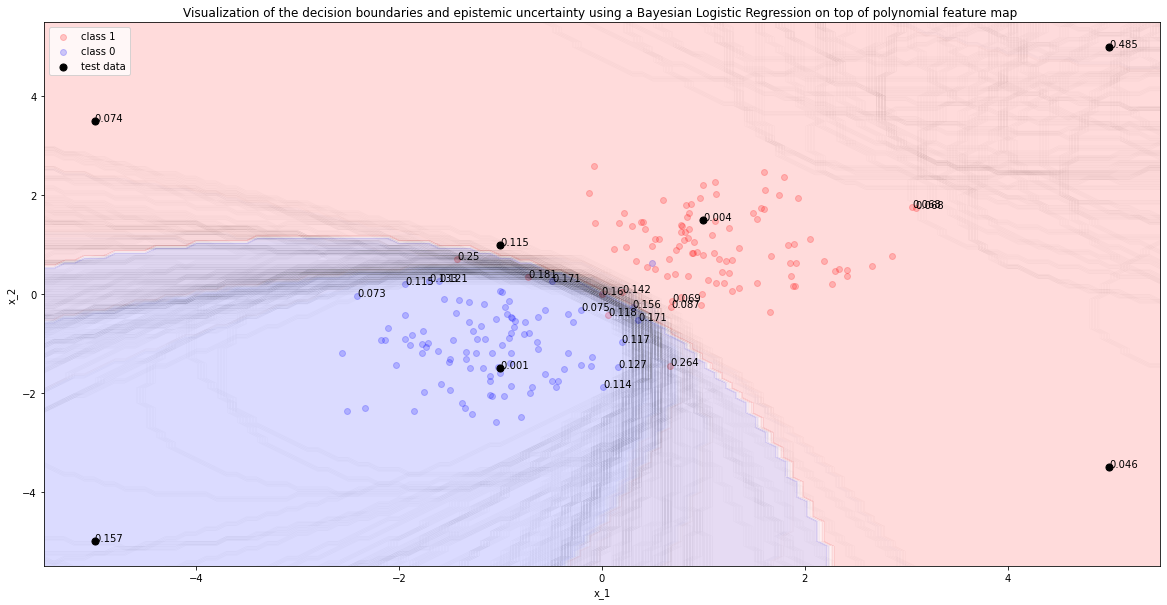

In [67]:
fig, ax = plt.subplots(1, figsize =(20, 10))
ax.set_title('Visualization of the decision boundaries and epistemic uncertainty using a Bayesian Logistic Regression on top of polynomial feature map ')
choices = np.random.choice(len(models_posterior_fm), size=100)
models_posterior_fm_plot = np.asarray(models_posterior_fm)[choices]
plot_decision_boundary(x, y, models_posterior_fm_plot, ax, poly_degree=2, test_points=test_points, shaded=True)
for i, txt in enumerate(test_variance_plot):
    ax.annotate(txt, (test_points[i][0], test_points[i][1]))
for i, txt in enumerate(train_variance_plot):
    if float(txt) > 0.05: 
        ax.annotate(txt, (x[i][0], x[i][1]))
plt.show(fig)

Now, the same kind of behavior occurs: high epistemic uncertainties are attributed for points near to the boundary decision. However, we can see some **new trends**: test data points located very far from the polynomial boundaries and in-distribution samples are alloted some high epistemic uncertainty. From what we have seen earlier, for the points lying at the boundary, it might me the in-distribution uncertainty, coming from the fact that our Bayesian Polynomial Logistic Regression does not know how to classify these points. However, for the two points located far from the boundary, we observe high epistemic uncertainty, and this time, it is **OOD uncertainty**. Therefore, I do not know if the Bayesian Polynomial Logistic Regression is able to identify all the OOD points, but it is the most reliable model we have seen until now.  

**Exercise 7: (Classifying OOD Data for a Toy Dataset with Bootstrap Non-linear Logistic Regression)** Perform bootstrap Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Obtain 100 bootstrap Logistic Regression models:
`LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`.

Visualize the decision boundaries corresponding to the samples in the bootstrap ensemble. Are the epistemic uncertainties of this ensemble able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries of the models in the ensemble. Using this geometric relationship, explain whether or not the epistemic uncertainties of our bootstrap ensemble is capable of distinguishing **all** possible OOD points.

In [82]:
poly = PolynomialFeatures(degree=2, include_bias=False).fit(x)
x_poly_MLE = poly.transform(x)
test_poly_MLE = poly.transform(test_points)

In [78]:
models_MLE = []
for _ in it.repeat(None, 100):
    bootstrap_indices = np.random.choice(np.arange(0, len(y)), size=len(y))
    X_bootstrap = x_poly_MLE[bootstrap_indices]
    y_bootstrap = y[bootstrap_indices]
    logistic = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    logistic.fit(X_bootstrap, y_bootstrap)
    models_MLE.append(logistic)

In [83]:
predictions_proba_train = []
predictions_proba_test = []
for model in models_MLE:
    predictions_proba_train.append(model.predict_proba(x_poly_MLE)[:, 1])
    predictions_proba_test.append(model.predict_proba(test_poly_MLE)[:, 1])
variance_train = np.std(np.asarray(predictions_proba_train), axis=0)
variance_test = np.std(np.asarray(predictions_proba_test), axis=0)

In [84]:
test_variance_plot = [round(var, 3) for var in variance_test]
train_variance_plot = [round(var, 3) for var in variance_train]

ValueError: X has 5 features per sample; expecting 6

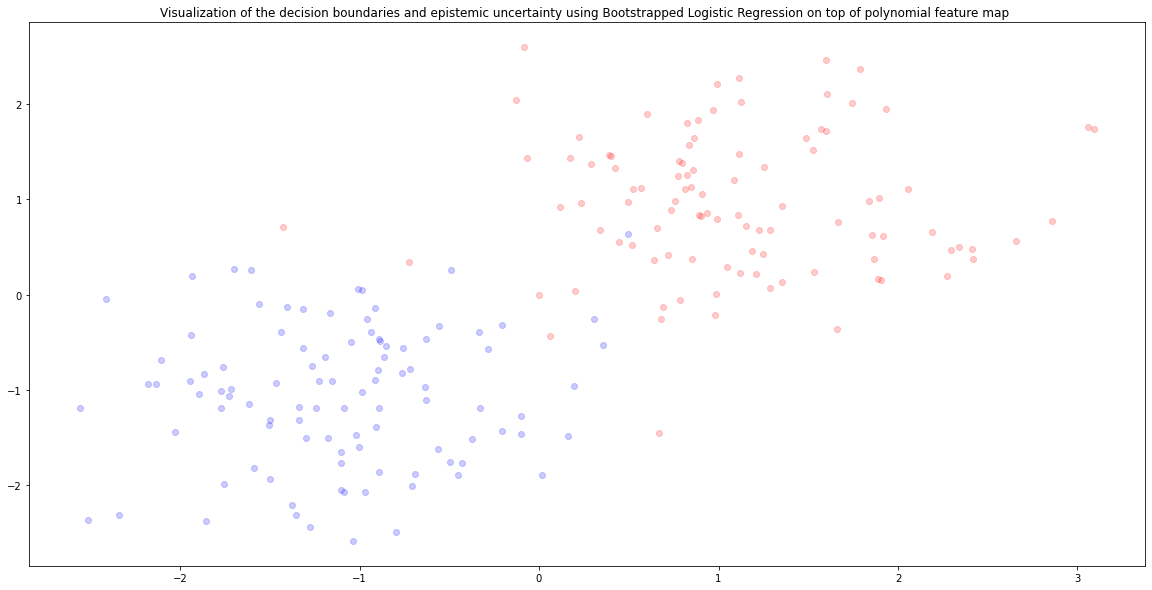

In [71]:
fig, ax = plt.subplots(1, figsize =(20, 10))
ax.set_title('Visualization of the decision boundaries and epistemic uncertainty using Bootstrapped Logistic Regression on top of polynomial feature map ')
plot_decision_boundary(x, y, models_MLE, ax, poly_degree=2, test_points=test_points, shaded=True)
for i, txt in enumerate(test_variance_plot):
    ax.annotate(txt, (test_points[i][0], test_points[i][1]))
for i, txt in enumerate(train_variance_plot):
    if float(txt) > 0.05: 
        ax.annotate(txt, (x[i][0], x[i][1]))
plt.show(fig)

We can see that the MLE Logistic Regression behaves poorly in term of predictive uncertainty. The epistemic uncertainty is quite low even for points lying at the boundary decision and is 0 for OOD samples lying far from the boundary decision. The epistemic uncertainties of our bootstrap ensemble is not capable of distinguishing all possible OOD points.

**Exercise 8: (Classifying OOD Data for MNIST)** Fit a Bayesian Logistic Regression model on the MNIST data. Estimate the average epistemic uncertainty, under the posterior $p(\mathbf{w} | \mathcal{D}))$, of the data points in the training dataset, then estimate the epistemic uncertainty of each test image. Are the epistimic uncertainties from this model able to distinguish in-distribution points from OOD points?

You may need to use `pymc3`'s HMC sampler to obtain samples from $p(\mathbf{w} | \mathcal{D}))$, since your own implementation of HMC may very likely to be too slow. 

Why is HMC sampling slower for MNIST than it is for our toy classification data? Describe how well you expect HMC to scale for a Bayesian Logistic Regression model with degree $D$ polynomial features on MNIST? **Hint:** think about how many parameters are in the likelihood of a Bayesian Logistic Regression model with degree $D$ polynomial features. What does this say about the challenges of fitting Bayesian models to real-world datasets?

##### Sampling from the posterior Bayesian Logistic Regression

*I keep on getting very poor performances using pymc3. My code takes 3hours to run and I do not understand why. My code is correct though, I checked it on Google Collab.*

In [ ]:
"""
logistic_mnist = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
logistic_mnist.fit(X_subset, y_subset)

w_cov = 10*np.eye(784,dtype=np.float32)
w_mu = np.zeros(784)
y_subset
with Model() as bayesian_model:
    w = pm.MvNormal('w', mu=w_mu, cov=w_cov,shape=784)
    b = pm.Normal('b',0,10)
    prob = sigmoid(pm.math.dot(X_subset,w)+b)
    y = pm.Bernoulli('y',p=prob, observed=y_subset.reshape(-1, 1), shape=(600))
    trace = pm.sample(100, start = {'w': logistic_mnist.coef_[0], 'b': logistic_mnist.intercept_[0]},chains=1)
"""

In [ ]:
from pymc3 import model_to_graphviz, Model
model_to_graphviz(bayesian_logistic_regression)

HMC is slower for MNIST than it is for our toy classification data because it is not scalable. Indeed, during HMC, we need to compute the gradients of the Energy function, which is the gradient of the negative log-likelihood of our training data. Therefore, we need to touch at every point of the training data. Since the size of our training data is bigger for MNIST than our toy classification data and since the dimensionality of a MNIST data point is 7XX against 2 for our toy example, the MNIST classification is more computationally expensive. Using a Bayesian Logistic Regression model with degree 𝐷 polynomial features on MNIST will exponentiate the number of features for every training point, which is already 784:this is going to be dramatic. And we are still working with *rather* simple Bayesian models (this is not a Deep BNN)! Therefore, performing Bayesian Inference in real-world datasets is a real challenge.

**Extra Credit Exercise 1: (The Impact of Hyperparameters and Number of Observations)** Vary the hyperparameters of the bootstrap ensemble and the Bayesian model to observe the effect of these parameters on the estimation of epistemic uncertainty. Consider a range of polynomial degrees, $D=[1, 2, 4, 10]$; consider a range of regularization strengths for Logistic Regression, `C=[1e-3, 1e-2, 1e-1, 1, 1e2, 1e3]`; consider a range of prior variances for Bayesian Logistic Regression, `alpha = [1e-3, 1e-1, 1, 1e2]`; finally, consider the number of observed data points in the training set, `N=[200, 600, 1000, 5000]`, note that the runtime of HMC will increase as $N$ increases.

**Extra Credit Exercise 2: (Classifying OOD Data for MNIST)** For which settings of hyperparameters is the epistemic uncertainties of the bootstrap ensemble able to distinguish in-distribution test images from OOD ones? For which settings of hyperparameters is the epistemic uncertainties of the Bayesian model able to distinguish in-distribution test images from OOD ones?


### Part III: What Uncertainties Do We Need in Classification?

**Exercise 9: (Comparing Bayesian and Frequnetist Epistemic Uncertainties)** In Homework #2, we saw that the epistemic uncertainties of frequentist and Bayesian uncertainties can be desirable or undesirable depending on the number of observations and the choices of hyperparameters (e.g. polynomial degree, variance of the prior in the Bayesian model, regularization strength of the models in the ensemble). For Bayesian and frequentist ensembles of classifiers, based on empirical results above, conjecture which factors affect the quality of epistemic uncertainties of Bayesian and bootstrap ensemble classifiers, respectively. Support your answer with what we know about the properties of Logistic Regression models.

In order to obtain epistemic uncertainties that can distinguish in-distribution and OOD points, what settings of hyperparameters do we need for Bayesian and bootstrap ensemble classifiers, respectively?


**Exercise 10: (Is OOD Detection Enough for Risk Adverse Applications?)** In the risk adverse real-life application you identified in Exercise 1, is accurate OOD detection enough to mitigate unwanted outcomes of deploying our model? That is, when classifiers are used in real-life applications where incorrect predictions can have disasterous consequence, what specific failure modes can these models experience? Are all of these failure modes addressed by proper detection of OOD inputs?

##### Comparing Bayesian and Frequentist Epistemic Uncertainties

**For Bayesian classifiers**:
- We saw that when polynomial degrees were too high, the epistemic uncertainties were completely off, since the behavior was uncontrollable even at the neighbor of in-distribution samples. Also, low degrees led to over-simple models not producing the desired variety to capture the OOD epistemic uncertainty. However, the effect of degree was not as dramatic as in the frequentist approach, because it was balanced with the effect of the prior.

- The prior variance was also to be selected carefully, for the same reasons.

- Increasing too much the number of training points reduce the effects of the prior, and kill the advantages of the Bayesian approach for Epistemic Uncertainty.

- Desired settings: high polynomial degree, reasonable variance, reasonable number of data points (high polynomial degree: create non-linear boundary, reasonable variance: produce variety in the way we fit function in OOD samples and create epistemic unceertainty, not a large amount of data: maintain the effect of the prior) 

**For frequentist approach**:
- The effect of regularization is opposed ot the desired epistemic uncertainty for OOD samples. 
- A high degree provokes a drmatic behavior in out-of-distribution regiosn, leading to non reliable epistemic uncertainty. 
- Last, increasing the number of training poitns allow to counter the effect of an increased polynomial degree. 
- Desired settings: unknown

##### Is OOD Detection Enough for Risk Adverse Applications?

Other than being over confident for OOD inputs, our models can experience a large range of difficulties during deployment. If our data is biased, then our results will be very poor. Inherently, even for in-distribution samples, our model can be off. The modelling phase of our model can also be completely off, and so on .. Therefore, not being able of detecting OOD inputs is just one amongst the **many** possible failure mode a model can encounter during the deployment phase.